# 1. Data Analysis of the Influencers:
# 2. Sentiment Analysis of the Influencers: 


In [1]:
#  TM -Import the Dependencies
import tweepy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime, timezone
import seaborn as sns
from os import path, makedirs # fetch path and makedirs function from os file
import csv # fetch csv file
from glob import glob # fetching glob function only from the glob lib

In [2]:
#  TM -Import keys from the config file
from config import consumer_key, consumer_secret, access_token, access_token_secret

In [3]:
#  TM - Twitter API Keys
# consumer_key = 'Your Key'
# consumer_secret = 'Your Key'
# access_token = 'Your Key'
# access_token_secret = 'Your Key'

In [4]:
# TM - Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [5]:
# TM - Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [6]:
#  TM - Load and read csv file containing the details of the Influencers 
influencer_data_load = "RawData/SentimentInfluencerInputData.csv"
influencer_data_read = pd.read_csv(influencer_data_load)

In [7]:
#  Team version merged.
# TM - for index, row in Influencers_DF.iterrows():
Data_Influencers_DF = influencer_data_read
Not_Found = 0

#  TM - Define variable for holding tweets for influencer

all_tweet_listing = []

print("-----------Start extraction!!!-----------")

for index, row in Data_Influencers_DF.iterrows():
    target_user = row["Twitter_Handle"]
    Genre =  row["Genre"]
    
    try:
        
        # TM -  retrieve top 200 tweets for influencer
        
        public_tweets = api.user_timeline(target_user, count=200, result_type="recent")

        # TM -  write to all_tweet_listing

        for tweet in public_tweets:
            
            Date = datetime.strptime(tweet['created_at'],'%a %b %d %H:%M:%S %z %Y').strftime('%m/%d/%Y')

            all_tweet_listing.append({"Influencer":target_user,
                               "Date": Date,
                               "Genre":Genre,
                               "Tweet":tweet["text"],
                               "Retweet_Count":tweet["retweet_count"]})
    
        user_account = api.get_user(target_user)
        user_geo_enabled = user_account["geo_enabled"]
        if (user_geo_enabled == True):
            Data_Influencers_DF.at[index, "Loc"] = user_account["location"]
        else:
            Data_Influencers_DF.at[index, "Loc"] = 'NA'

        if (user_account["lang"] == 'en'):
            Data_Influencers_DF.at[index, "Lang"] = 'Eng'
        else:
            Data_Influencers_DF.at[index, "Lang"] = 'NA'
        
        Data_Influencers_DF.at[index, "Created On"] = datetime.strptime(user_account['created_at'],'%a %b %d %H:%M:%S %z %Y').strftime('%m/%d/%Y')
        
        Data_Influencers_DF.at[index, "Age Of Account"] = (datetime.now(timezone.utc) - datetime.strptime(user_account['created_at'],'%a %b %d %H:%M:%S %z %Y')).days
        
        
       #  TM -  Data_Influencers_DF.at[index, "Real Name"] = user_real_name
        Data_Influencers_DF.at[index, "Tweets"] = user_account["statuses_count"]
        Data_Influencers_DF.at[index, "Followers"] = user_account["followers_count"]
        Data_Influencers_DF.at[index, "Following"] = user_account["friends_count"]
        Data_Influencers_DF.at[index, "Favorites Count"] = user_account["favourites_count"]
        
              
    
    except tweepy.TweepError as e:
        Not_Found = Not_Found + 1
        print(f"exception for {row['Twitter_Handle']}: {e}")

print("----------- Extraction Complete !!!-----------")        
print(Not_Found)

-----------Start extraction!!!-----------
exception for @ilanusglazer: Not authorized.
exception for @billieelish: Not authorized.
----------- Extraction Complete !!!-----------
2


In [8]:
# TM - translate dict to a dataframe
tweet_listing_pd = pd.DataFrame.from_dict(all_tweet_listing)

In [9]:
# TM - stats for tweet listing for influencers. PLEASE DON'T REMOVE. Required to quantify digital footprint!
tweet_listing_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68511 entries, 0 to 68510
Data columns (total 5 columns):
Date             68511 non-null object
Genre            68511 non-null object
Influencer       68511 non-null object
Retweet_Count    68511 non-null int64
Tweet            68511 non-null object
dtypes: int64(1), object(4)
memory usage: 2.6+ MB


In [10]:
# TM - top 1000 key words from Influencer tweets#SS -to 

Top_1000 = pd.Series(' '.join(tweet_listing_pd['Tweet']).lower().split()).value_counts()[:1000]

In [11]:
#  TM - Saving the out put into a csv file
Top_1000.to_csv("RawData/Top_1000_keywords.csv", index=True, header=True)

In [12]:
# TM -  Write to CSV for analysis
tweet_listing_pd.to_csv("RawData/TweetListings.csv", index=False, header=True)

In [13]:
# SS - String type casting for Tweets column

tweet_listing_pd.Tweet = tweet_listing_pd.Tweet.map(''.join).str.strip()

In [14]:
# SS - define target tags for social and entertainment

social_target_tags = ["#FamiliesBelongTogetherMarch","#gun","gun","shooting","gun-control","election","#metoo","metoo","FamiliesBelongTogetherMarch","PrideMonth","#PrideMonth","FamiliesBelongTogether","ChildreninCages","UniteTheFamilies","WeCare"]

entertainment_target_tags = ["#SocialMediaDay","SocialMediaDay","WorldCup","#WorldCup","#fifa","fifa", "#worldcup2018russia","#PostASongLyricYouLove"]


In [15]:
# SS - function to match tweet with tags

def matcher_tweet(x):
    for i in social_target_tags:
        if i.lower() in x.lower():
            return("Social")
        
    for j in entertainment_target_tags:
        if j.lower() in x.lower():
            return("Entertainment")

In [16]:
# SS - Add new column to tweet_listing_pd to capture Category - Social vs Entertainment

tweet_listing_pd['Tweet_Category'] = tweet_listing_pd['Tweet'].apply(matcher_tweet)

In [17]:
# SS - Analysis of tweet_listing_pd
tweet_listing_pd_sorted = tweet_listing_pd.sort_values("Retweet_Count",ascending=False)

tweet_listing_pd_sorted.head(10)

,Date,Genre,Influencer,Retweet_Count,Tweet,Tweet_Category
47045,08/13/2017,Politicians,@BarackObama,1696821,"""No one is born hating another person because ...",None
30446,09/01/2017,Sports_celeb,@gabrielledoug,1138633,RT @PennStateIFC: With the current devastation...,None
6835,01/11/2017,Actors,@TaySchilling,852889,RT @POTUS: Thank you for everything. My last a...,None
42878,09/23/2017,Sports_celeb,@rolopez42,644119,RT @KingJames: U bum @StephenCurry30 already s...,None
47016,11/20/2017,Politicians,@BarackObama,499481,"ME: Joe, about halfway through the speech, I’...",None
47044,08/13/2017,Politicians,@BarackObama,491151,"""People must learn to hate, and if they can le...",None
4881,08/13/2017,Actors,@EmilyVanCamp,491151,"RT @BarackObama: ""People must learn to hate, a...",None
4819,02/24/2018,Actors,@EmilyVanCamp,449120,RT @BarackObama: Young people have helped lead...,None
46997,02/22/2018,Politicians,@BarackObama,449120,Young people have helped lead all our great mo...,None
5712,02/22/2018,Actors,@smashleybell,449120,RT @BarackObama: Young people have helped lead...,None


In [18]:
# SS - Genre vs Catgegory
tweet_listing_pd_sorted_Summary = tweet_listing_pd_sorted.groupby(["Tweet_Category","Genre"],as_index=False).count()
tweet_listing_DF = tweet_listing_pd_sorted_Summary[["Tweet_Category","Genre","Tweet"]]
tweet_listing_DF

,Tweet_Category,Genre,Tweet
0,Entertainment,Actors,14
1,Entertainment,Comedians,2
2,Entertainment,Economists,12
3,Entertainment,Musicians,15
4,Entertainment,Politicians,3
5,Entertainment,Social_workers,1
6,Entertainment,Sports_celeb,34
7,Social,Actors,111
8,Social,Comedians,101
9,Social,Economists,42


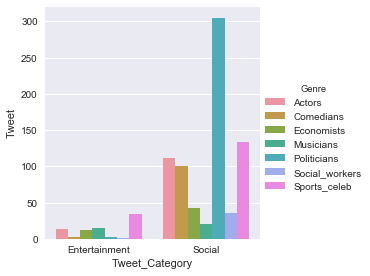

In [19]:
# SS  - Plot Tweet Category vs Number of Tweets

import seaborn as sns
sns.set()

sns.factorplot(x='Tweet_Category', y='Tweet', hue='Genre', data=tweet_listing_DF, kind='bar')

plt.show()

In [20]:
#  TM - Remove the records of people who have not tweeted at all
Data_Influencers_DF = Data_Influencers_DF[Data_Influencers_DF['Tweets']>0]

In [21]:
#  TM -  Remove missing values.
Data_Influencers_DF.dropna()

Data_Influencers_DF.to_csv('OutPut/Influencer_Analysis.csv')

In [22]:
#  TM - Print the DF
Data_Influencers_DF

,Twitter_Handle,First_Name,Last_Name,Genre,Loc,Lang,Created On,Age Of Account,Tweets,Followers,Following,Favorites Count
0,@_AnneHathaway,Anne,Hathaway,Actors,NA,Eng,09/13/2012,2118.0,2.0,282.0,0.0,0.0
1,@IAMannalynnemcc,AnnaLynne,McCord,Actors,NA,Eng,01/16/2010,3090.0,5776.0,228657.0,502.0,2157.0
2,@EmmaWatson,Emma,Watson,Actors,NA,Eng,07/14/2010,2910.0,1642.0,29143216.0,382.0,991.0
4,@LeoDiCaprio,Leonardo,DiCaprio,Actors,NA,Eng,04/16/2010,2999.0,1285.0,19327180.0,145.0,40.0
5,@EvaLongoria,Eva,Baston,Actors,"Los Angeles, CA",Eng,02/02/2010,3072.0,15806.0,7691876.0,809.0,151.0
6,@TheRock,Dwayne,Johnson,Actors,NA,Eng,02/11/2011,2698.0,21662.0,13044259.0,242.0,142.0
7,@jessicaalba,Jessica,Alba,Actors,NA,Eng,11/24/2009,3142.0,6244.0,9649191.0,1359.0,1442.0
8,@EllenPompeo,Ellen,Pompeo,Actors,NY/LA,Eng,03/23/2013,1928.0,5211.0,1551708.0,541.0,6060.0
9,@JessicaCapshaw,Jessica,Capshaw,Actors,NA,Eng,05/05/2011,2615.0,4017.0,935946.0,348.0,86.0
10,@sarahdrew,Sarah,Drew,Actors,NA,Eng,11/14/2009,3153.0,9611.0,822552.0,201.0,622.0


In [23]:
#   TM - Grouped on Genre 
#   TM - Data_Influencers_DF.is_copy = False. The .copy() helps to get rid of warning.

Data_Influencers_DF['Average Tweets'] = Data_Influencers_DF['Tweets'].copy()
Data_Influencers_DF['Count'] = 0


AggregatedGenre = Data_Influencers_DF.groupby(["Genre"]).agg({'Genre': 'min', 'Tweets': 'sum', 'Followers': 'sum','Average Tweets':'mean','Age Of Account':'mean','Count':'size'})

AggregatedGenre.sort_values(['Followers'], ascending =False)


C:\Users\Inna\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Inna\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Genre,Tweets,Followers,Average Tweets,Age Of Account,Count
Genre,,,,,,
Musicians,Musicians,455085.0,919362961.0,10583.372093,3075.767442,43
Sports_celeb,Sports_celeb,896670.0,512195341.0,7598.898305,2794.949153,118
Politicians,Politicians,575159.0,247625927.0,7878.890411,2821.671233,73
Comedians,Comedians,481405.0,210181493.0,11195.465116,3142.348837,43
Actors,Actors,387975.0,102835738.0,9462.804878,2690.048780,41
Social_workers,Social_workers,350911.0,11884102.0,25065.071429,2874.928571,14
Economists,Economists,580014.0,2194922.0,22308.230769,2852.000000,26


In [24]:
#   TM - Sorting on Average Tweets and grouped on Genere
AggregatedGenre.sort_values(['Average Tweets'],ascending=False)

,Genre,Tweets,Followers,Average Tweets,Age Of Account,Count
Genre,,,,,,
Social_workers,Social_workers,350911.0,11884102.0,25065.071429,2874.928571,14
Economists,Economists,580014.0,2194922.0,22308.230769,2852.000000,26
Comedians,Comedians,481405.0,210181493.0,11195.465116,3142.348837,43
Musicians,Musicians,455085.0,919362961.0,10583.372093,3075.767442,43
Actors,Actors,387975.0,102835738.0,9462.804878,2690.048780,41
Politicians,Politicians,575159.0,247625927.0,7878.890411,2821.671233,73
Sports_celeb,Sports_celeb,896670.0,512195341.0,7598.898305,2794.949153,118


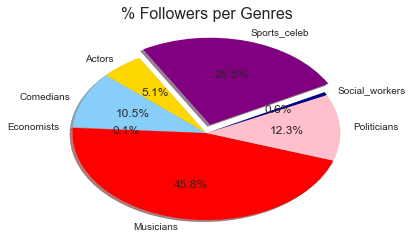

In [25]:
 ## TM - whole cell
# Labels for the sections of our pie chart
labels = AggregatedGenre['Genre']

# The values of each section of the pie chart
# sizes = Data_Influencers_DF.groupby(["Genere"],as_index=False).sum()["fare"].tolist()
sizes = AggregatedGenre['Followers']

# The colors of each section of the pie chart
colors = ["gold", "lightskyblue", "lightcoral",'red','pink','darkblue','purple']

# Tells matplotlib to seperate the "Python" section from the others
explode = (0,0,0,0,0,0,0.1)

# Creates the pie chart based upon the values above
# Automatically finds the percentages of each part of the pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=120)

# Tells matplotlib that we want a pie chart with equal axes
plt.axis("off")

  
plt.title("% Followers per Genres", fontsize=16)

plt.savefig('Images/% Followers per Genres.png')
# Prints our pie chart to the screen
plt.show()

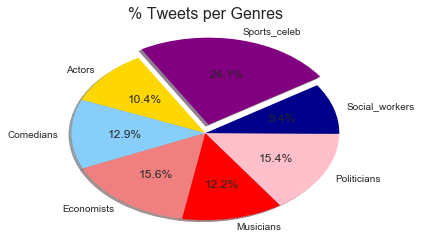

In [26]:
 ## TM - whole cell
# Labels for the sections of our pie chart
labels = AggregatedGenre['Genre']

# The values of each section of the pie chart
# sizes = Data_Influencers_DF.groupby(["Genere"],as_index=False).sum()["fare"].tolist()
sizes = AggregatedGenre['Tweets']

# The colors of each section of the pie chart
colors = ["gold", "lightskyblue", "lightcoral",'red','pink','darkblue','purple']

# Tells matplotlib to seperate the "Python" section from the others
explode = (0,0,0,0,0,0,0.1)

# Creates the pie chart based upon the values above
# Automatically finds the percentages of each part of the pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=120)

# Tells matplotlib that we want a pie chart with equal axes
plt.axis("off")

  
plt.title("% Tweets per Genres", fontsize=16)

plt.savefig('Images/% Tweets per Genres.png')
# Prints our pie chart to the screen
plt.show()

In [27]:
# -TM - People who are top ten Influencer who tweet more
top_ten_twitters = Data_Influencers_DF.sort_values(['Tweets'],ascending=False).head(10)
top_ten_twitters

,Twitter_Handle,First_Name,Last_Name,Genre,Loc,Lang,Created On,Age Of Account,Tweets,Followers,Following,Favorites Count,Average Tweets,Count
332,@Noahpinion,Noah,Smith,Economists,NA,Eng,04/14/2011,2637.0,140980.0,102403.0,810.0,211850.0,140980.0,0
359,@BDUTT,Barkha,Dutt,Social_workers,India,Eng,02/02/2009,3437.0,118526.0,6818754.0,1574.0,27906.0,118526.0,0
356,@ProfessorChic,Jamie,Mitchell,Social_workers,NA,Eng,04/04/2011,2647.0,79769.0,1456.0,572.0,24906.0,79769.0,0
339,@haroldpollack,Harold,Pollack,Economists,NA,Eng,12/25/2009,3112.0,65253.0,20537.0,2427.0,7088.0,65253.0,0
276,@CoryBooker,Cory,Booker,Politicians,"Newark, NJ",Eng,08/11/2008,3613.0,61946.0,4121795.0,93080.0,91.0,61946.0,0
325,@MarkThoma,Mark,Thoma,Economists,NA,Eng,10/18/2008,3545.0,60106.0,44683.0,417.0,5.0,60106.0,0
82,@iliza,Iliza,Shiesinger,Comedians,"Hollywood, CA",Eng,02/15/2009,3425.0,49175.0,170279.0,468.0,27103.0,49175.0,0
125,@IGGYAZALEA,Iggy,Azalea,Musicians,"California, USA",Eng,06/09/2010,2946.0,47711.0,8083765.0,6511.0,4224.0,47711.0,0
216,@criscyborg,Cris,Cyborg,Sports_celeb,cris.cyborg.llc@gmail.com,Eng,11/29/2009,3138.0,46479.0,191740.0,2134.0,12433.0,46479.0,0
352,@socworkpodcast,Jonathan,Singer,Social_workers,"Chicago, IL",Eng,09/09/2009,3219.0,45426.0,14252.0,793.0,22421.0,45426.0,0


In [28]:
# AggregatedGenre

In [29]:
#  -TM - Top ten Influencer who who have more Followers
top_ten_influencer = Data_Influencers_DF.sort_values(['Followers'],ascending=False).head(10)
top_ten_influencer

,Twitter_Handle,First_Name,Last_Name,Genre,Loc,Lang,Created On,Age Of Account,Tweets,Followers,Following,Favorites Count,Average Tweets,Count
91,@katyperry,Katy,Perry,Musicians,,Eng,02/20/2009,3419.0,9220.0,109577958.0,216.0,6214.0,9220.0,0
251,@BarackObama,Barack,Obama,Politicians,NA,Eng,03/05/2007,4137.0,15517.0,103468481.0,621131.0,11.0,15517.0,0
86,@taylorswift13,Taylor,Swift,Musicians,NA,Eng,12/06/2008,3496.0,100.0,85542986.0,0.0,458.0,100.0,0
95,@ladygaga,Lady,Gaga,Musicians,NA,Eng,03/26/2008,3750.0,8764.0,78902605.0,127004.0,1915.0,8764.0,0
66,@TheEllenShow,Ellen,DeGeneres,Comedians,California,Eng,08/14/2008,3610.0,16970.0,78053544.0,35730.0,954.0,16970.0,0
139,@Cristiano,Cristiano,Ronaldo,Sports_celeb,Madrid,NA,06/14/2010,2941.0,3212.0,74239840.0,99.0,0.0,3212.0,0
105,@jtimberlake,Justin,Timberlake,Musicians,"Memphis, TN",Eng,03/25/2009,3387.0,3976.0,66046523.0,282.0,192.0,3976.0,0
107,@BritneySpears,Britney,Spears,Musicians,NA,Eng,09/22/2008,3570.0,5475.0,58238917.0,386044.0,2554.0,5475.0,0
87,@ArianaGrande,Ariana,Grande,Musicians,ǝʌɐ uooɯʎǝuoɥ,Eng,04/23/2009,3358.0,41436.0,57677354.0,64047.0,34191.0,41436.0,0
122,@ddlovato,Demi,Lovato,Musicians,DALLAS/LA,Eng,02/17/2009,3423.0,17085.0,57283232.0,539.0,2098.0,17085.0,0


In [30]:
#--RR Still Working test cell
# to find the handle of followers of the top most 
# active Influencer so that we can send the tweet through a bot.
# top_ten_twitters.head(1)['Twitter_Handle'].map(lambda x: x.lstrip('@'))
# import time
# ids = []
# for page in tweepy.Cursor(api.followers_ids, top_ten_twitters.head(1)['Twitter_Handle'].map(lambda x: x.lstrip('@'))).pages():
#     ids.extend(page)
#     time.sleep(60)

# 2. Sentiment Analysis of the Influencers: 

In [31]:
# # -TM - Extract the first 1000 tweets of the Influencers
print("-----------Start extraction of the tweets posted by the Influencers!!!-----------")
Influencers = top_ten_influencer['Twitter_Handle']
Sentiment_array = []

for user in Influencers:
    # Set the tweet count to 100
    tweet_count = 1000
    print("Extracting tweets from %s"%user)
    
    # Extract tweets up to 5 pages
    for x in range(10):
        influencer_tweets = api.user_timeline(user,page = x)
# influencer_tweets        
        
        # For each tweet in a bunch of public tweets
        for tweet in influencer_tweets:
            
            #Calculate the compound, positive, negative and neutral values of each tweet
            compound = analyzer.polarity_scores(tweet["text"])["compound"]
            pos = analyzer.polarity_scores(tweet["text"])["pos"]
            neu = analyzer.polarity_scores(tweet["text"])["neu"]
            neg = analyzer.polarity_scores(tweet["text"])["neg"]
            
            age_of_tweet = (datetime.now(timezone.utc) - datetime.strptime(tweet['created_at'],'%a %b %d %H:%M:%S %z %Y')).days
            tweetAge = 0 
            if age_of_tweet < 180:
                tweetAge = 1
            elif age_of_tweet < 365:   
                tweetAge = 2
            else:
                tweetAge = 3
            
 
            
            # Save the Tweets in an array as a dictionery item 
            Sentiment_array.append({"Influencers" : user,
                                    "Tweet Text" : tweet["text"],
                                    "Compound" : compound,
                                    "Positive" : pos,
                                    "Negative" : neg,
                                    "Neutral" : neu,
                                    "Date" : datetime.strptime(tweet["created_at"],'%a %b %d %H:%M:%S %z %Y').strftime('%m/%d/%Y'),
                                    "AgeOfTweet":age_of_tweet,
                                    "TweetAgeType":tweetAge,
                                    "Tweets Ago": tweet_count
                                   })
            
            #Decrease count of tweet by 1 in the reverse order
            tweet_count -= 1

print("-----------End of Extraction of Tweets !!!-----------")

-----------Start extraction of the tweets posted by the Influencers!!!-----------
Extracting tweets from @katyperry
Extracting tweets from @BarackObama
Extracting tweets from @taylorswift13
Extracting tweets from @ladygaga
Extracting tweets from @TheEllenShow
Extracting tweets from @Cristiano
Extracting tweets from @jtimberlake
Extracting tweets from @BritneySpears
Extracting tweets from @ArianaGrande
Extracting tweets from @ddlovato
-----------End of Extraction of Tweets !!!-----------


In [32]:
# # RR Sentiment_array
# Sentiment_array['TweetAge'] = 3

# Sentiment_array.loc[Sentiment_array['AgeOfTweet'] < 180, 'TweetAge'] = 1
# Sentiment_array.loc[Sentiment_array['AgeOfTweet'] > 180 & Sentiment_array['AgeOfTweet'] < 365, 'TweetAge'] = 2
# Sentiment_array

In [33]:
# -TM - whole Cell
# Create dataframe from the Dictionery item of the Sentiment Array
Sentiment_DF = pd.DataFrame.from_dict(Sentiment_array)

# -TM -Remove the '@' from the 'influence' column in the data frame
Sentiment_DF["Influencers"] = Sentiment_DF["Influencers"].map(lambda x: x.lstrip('@'))

# -TM - Re_arrang the columns and save into a CSV file
Sentiment_DF = Sentiment_DF[["Influencers", "Date", "Tweet Text"
                             , "Compound", "Positive", "Negative"
                             , "Neutral", "Tweets Ago","AgeOfTweet","TweetAgeType"
                            ]]

# -TM -Store output in a .CSV File
Sentiment_DF.to_csv("OutPut/influencer_Sentiment_tweets_Analysis.csv")

Sentiment_DF

,Influencers,Date,Tweet Text,Compound,Positive,Negative,Neutral,Tweets Ago,AgeOfTweet,TweetAgeType
0,katyperry,07/03/2018,My ❤ was touched by Carter's story. If you're ...,0.2500,0.214,0.107,0.679,1000,0,1
1,katyperry,06/23/2018,Was so proud to give the gift of #transcendent...,0.8805,0.362,0.000,0.638,999,10,1
2,katyperry,06/22/2018,found my first skin tag today. I think I’m an ...,0.0000,0.000,0.000,1.000,998,11,1
3,katyperry,06/21/2018,"Never forget, everyone was once a child.",0.1695,0.250,0.000,0.750,997,12,1
4,katyperry,06/20/2018,My Aussies 🐨 &amp; Kiwis 🥝! For the FINALE of ...,0.0000,0.000,0.000,1.000,996,12,1
5,katyperry,06/15/2018,"I 👁 you, @RoarForJess, and I ❤ you, and I’m si...",0.0000,0.000,0.000,1.000,995,18,1
6,katyperry,06/09/2018,Scandinavians have figured it out.,0.0000,0.000,0.000,1.000,994,23,1
7,katyperry,06/09/2018,Oi oi @JackGarratt remember when we locked our...,0.0000,0.000,0.000,1.000,993,24,1
8,katyperry,06/09/2018,WITNESS IS 1⃣❗🎂 🎈 https://t.co/fz83TjrJUr http...,0.0000,0.000,0.000,1.000,992,24,1
9,katyperry,06/06/2018,IM SCREAMINGOSBEJRMF$&amp;2@!K https://t.co/Sn...,0.0000,0.000,0.000,1.000,991,27,1


In [34]:
# -TM -Get the unique list of the influencers
Influencers_array = Sentiment_DF["Influencers"].unique()
Influencers_array

array(['katyperry', 'BarackObama', 'taylorswift13', 'ladygaga',
       'TheEllenShow', 'Cristiano', 'jtimberlake', 'BritneySpears',
       'ArianaGrande', 'ddlovato'], dtype=object)

In [35]:
# -TM -Calculate the mean for each Influencers & store into a dataframe
Influencers_Comp_Mean = Sentiment_DF.groupby("Influencers").mean()["Compound"].to_frame()

#-TM -Reset the index 
Influencers_Comp_Mean.reset_index(inplace=True)

Influencers_Comp_Mean

,Influencers,Compound
0,ArianaGrande,0.200119
1,BarackObama,0.343343
2,BritneySpears,0.379596
3,Cristiano,0.222748
4,TheEllenShow,0.364944
5,ddlovato,0.212090
6,jtimberlake,0.210583
7,katyperry,0.185715
8,ladygaga,0.347224
9,taylorswift13,0.183432


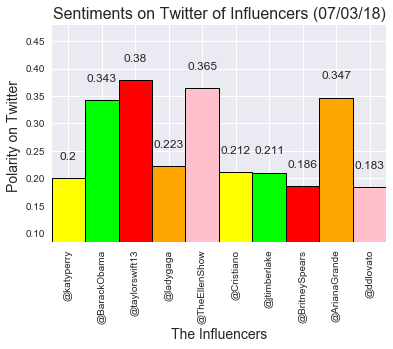

In [36]:
# -TM - Whole cell
# Set the values for x_axis & y_axis
x_axis = Influencers_Comp_Mean.index.values
y_axis = Influencers_Comp_Mean["Compound"]
X_Label = Influencers

# Intialize the plots. 
fig,ax = plt.subplots()#  function that returns a tuple containing a figure and axes object(s)

#Set the plot and assign the values like colors etc
bars = ax.bar(x_axis,y_axis
              , align = "edge"
              , width = 1
              , linewidth = 1
              , edgecolor = 'black'
              , color = ["yellow","lime","red","orange","pink"]
             )

# Set the tick(s) of the bar graph
tick_locations = [value + 0.5 for value in range(len(x_axis))]
plt.xticks(tick_locations,X_Label,rotation='vertical')

# If value is positive then put True in the Summary else place False
Influencers_Comp_Mean["Positive"] = Influencers_Comp_Mean["Compound"] > 0

# Assign the height based on positive value after allocating True / false value
height = Influencers_Comp_Mean.Positive.map({True: 0.03 , False: -0.03})

# # Set the value on labels on the bars
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + height[bars.index(bar)]
            , round(Influencers_Comp_Mean["Compound"][bars.index(bar)],3)
            , ha = 'center'
            , va = 'bottom'
            )

# Set the x_axis limits
ax.set_xlim(0, len(x_axis))

# Dynamically set the y_axis limits by finding the max & min value of y-axis
ax.set_ylim(min(y_axis)-0.1, max(y_axis) + 0.1)

# Set a horizontal line at y = 0
plt.hlines(0,0,len(x_axis))

# Title of the graph
ax.set_title("Sentiments on Twitter of Influencers (%s)" % (time.strftime("%x")), fontsize=16)

# Setting the y_axis label
ax.set_ylabel("Polarity on Twitter ", fontsize=14)

# # Setting the x_axis label
ax.set_xlabel("The Influencers", fontsize=14)
  
# Saving the graph
plt.savefig("Images/The Influencer Twitter Sentiment.png",bbox_inches='tight')
plt.show()

In [37]:
# IB People who are top 5 Influencer, with the greatest number of followers
top_5_influencer = Data_Influencers_DF.sort_values(['Followers'],ascending=False).head(5)
top_5_influencer

,Twitter_Handle,First_Name,Last_Name,Genre,Loc,Lang,Created On,Age Of Account,Tweets,Followers,Following,Favorites Count,Average Tweets,Count
91,@katyperry,Katy,Perry,Musicians,,Eng,02/20/2009,3419.0,9220.0,109577958.0,216.0,6214.0,9220.0,0
251,@BarackObama,Barack,Obama,Politicians,NA,Eng,03/05/2007,4137.0,15517.0,103468481.0,621131.0,11.0,15517.0,0
86,@taylorswift13,Taylor,Swift,Musicians,NA,Eng,12/06/2008,3496.0,100.0,85542986.0,0.0,458.0,100.0,0
95,@ladygaga,Lady,Gaga,Musicians,NA,Eng,03/26/2008,3750.0,8764.0,78902605.0,127004.0,1915.0,8764.0,0
66,@TheEllenShow,Ellen,DeGeneres,Comedians,California,Eng,08/14/2008,3610.0,16970.0,78053544.0,35730.0,954.0,16970.0,0


In [38]:
#IB Working Module --  Extract the first 100 tweets of the top ten Influencers

# Extract the first 100 tweets of the Influencers
print("-----------Start extraction of the tweets posted by the Influencers!!!-----------")
Influencers = []
Influencers = top_5_influencer["Twitter_Handle"]
Influencers

# IB Influencer's overall sentiments
Influencers_overall_results = []

Sentiment_array_infl = []

# IB loop through each top ten influencer
for user in Influencers:
    
   # IB Variables for holding compound sentiments
    compound_list = []
    
    # IB Variable for max_id
    oldest_tweet = None
    
    # Set the tweet count to 100
    tweet_count = 0
    print("Extracting tweets from %s"%user)
    
    # Extract tweets up to 5 pages
    for x in range(5):
        ### IB - it is working - print(f"For page number: '{x}' ")
        influencer_tweets = api.user_timeline(user,page = x,  max_id = oldest_tweet )       
        
        # For each tweet in a bunch of public tweets
        for tweet in influencer_tweets:
            
            #Calculate the compound, positive, negative and neutral values of each tweet
            compound = analyzer.polarity_scores(tweet["text"])["compound"]
            pos = analyzer.polarity_scores(tweet["text"])["pos"]
            neu = analyzer.polarity_scores(tweet["text"])["neu"]
            neg = analyzer.polarity_scores(tweet["text"])["neg"]
            
            # Save the Tweets in an array as a dictionery item 
            Sentiment_array_infl.append({"Influencers" : user,
                                    "Tweet Text" : tweet["text"],
                                    "Compound" : compound,
                                    "Positive" : pos,
                                    "Negative" : neg,
                                    "Neutral" : neu,
                                    "Date" : tweet["created_at"],
                                    "Tweets Ago" : tweet_count
                                   })
            
            # IB Collect compund sentiments for each Infuencer
            compound_list.append(compound)
            
            #Decrease count of tweet by 1 in the reverse order
            tweet_count += 1
            
        # IB get Tweet ID, subtract 1,assign to oldest_tweet
        oldest_tweet = tweet["id"] - 1
        
    # IB List for dictionary of results for _overall_ sentiments for each user
    Influencers_overall_results.append({"Influencer": user, "Overall Sentiment": np.mean(compound_list)})

print("-----------End of Extraction of Tweets !!!-----------")
###Influencers_overall_results

-----------Start extraction of the tweets posted by the Influencers!!!-----------
Extracting tweets from @katyperry
Extracting tweets from @BarackObama
Extracting tweets from @taylorswift13
Extracting tweets from @ladygaga
Extracting tweets from @TheEllenShow
-----------End of Extraction of Tweets !!!-----------


In [39]:
# IB Prepare Results Dataframe for the scatter plot
Influencers_overall_results_df = pd.DataFrame.from_dict(Sentiment_array_infl)
Influencers_overall_results_df.head(10)

,Compound,Date,Influencers,Negative,Neutral,Positive,Tweet Text,Tweets Ago
0,0.2500,Tue Jul 03 19:50:15 +0000 2018,@katyperry,0.107,0.679,0.214,My ❤ was touched by Carter's story. If you're ...,0
1,0.8805,Sat Jun 23 01:18:28 +0000 2018,@katyperry,0.000,0.638,0.362,Was so proud to give the gift of #transcendent...,1
2,0.0000,Fri Jun 22 19:27:57 +0000 2018,@katyperry,0.000,1.000,0.000,found my first skin tag today. I think I’m an ...,2
3,0.1695,Thu Jun 21 02:10:52 +0000 2018,@katyperry,0.000,0.750,0.250,"Never forget, everyone was once a child.",3
4,0.0000,Wed Jun 20 21:10:37 +0000 2018,@katyperry,0.000,1.000,0.000,My Aussies 🐨 &amp; Kiwis 🥝! For the FINALE of ...,4
5,0.0000,Fri Jun 15 19:50:07 +0000 2018,@katyperry,0.000,1.000,0.000,"I 👁 you, @RoarForJess, and I ❤ you, and I’m si...",5
6,0.0000,Sat Jun 09 23:51:56 +0000 2018,@katyperry,0.000,1.000,0.000,Scandinavians have figured it out.,6
7,0.0000,Sat Jun 09 14:02:29 +0000 2018,@katyperry,0.000,1.000,0.000,Oi oi @JackGarratt remember when we locked our...,7
8,0.0000,Sat Jun 09 04:08:27 +0000 2018,@katyperry,0.000,1.000,0.000,WITNESS IS 1⃣❗🎂 🎈 https://t.co/fz83TjrJUr http...,8
9,0.0000,Wed Jun 06 17:11:41 +0000 2018,@katyperry,0.000,1.000,0.000,IM SCREAMINGOSBEJRMF$&amp;2@!K https://t.co/Sn...,9


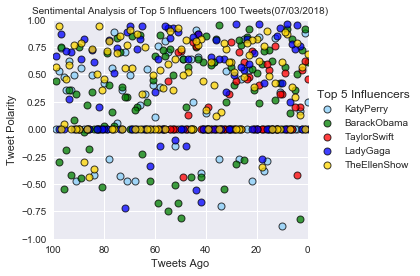

In [40]:
# IB Creating Sentiment Analysis for Top Ten Influences (07/02/2018) Scatter Plot

# Separate media_user_results_df Dataset into 5 parts/ datasets by "Media Source"
inf1_tweet_data_df = Influencers_overall_results_df[Influencers_overall_results_df['Influencers'] == "@katyperry"] 
inf2_tweet_data_df = Influencers_overall_results_df[Influencers_overall_results_df['Influencers'] == "@BarackObama"] 
# For each of media sources following the first one in the media dataset reset index to 0-99
# in order to plot in the common area
inf2_tweet_data_df = inf2_tweet_data_df.reset_index(drop=True)
inf3_tweet_data_df = Influencers_overall_results_df[Influencers_overall_results_df['Influencers'] == "@taylorswift13"] 
inf3_tweet_data_df = inf3_tweet_data_df.reset_index(drop=True)
inf4_tweet_data_df = Influencers_overall_results_df[Influencers_overall_results_df['Influencers'] == "@ladygaga"] 
inf4_tweet_data_df = inf4_tweet_data_df.reset_index(drop=True)
inf5_tweet_data_df = Influencers_overall_results_df[Influencers_overall_results_df['Influencers'] == "@TheEllenShow"] 
inf5_tweet_data_df = inf5_tweet_data_df.reset_index(drop=True)

# Get the values for each part of the scatter plot by "Influencers"
# INF1
# Get values for X axis
inf1_tweet_ago_data = inf1_tweet_data_df.index
# Get values for Y axis
inf1_tweet_polarity_data = inf1_tweet_data_df["Compound"] 
####################################################################
# INF2
# Get values for X axis
inf2_tweet_ago_data = inf2_tweet_data_df.index 
# Get values for Y axis
inf2_tweet_polarity_data = inf2_tweet_data_df["Compound"] 
####################################################################
# INF3
# Get values for X axis
inf3_tweet_ago_data = inf3_tweet_data_df.index
# Get values for Y axis
inf3_tweet_polarity_data = inf3_tweet_data_df["Compound"] 
####################################################################
# INF4
# Get values for X axis
inf4_tweet_ago_data = inf4_tweet_data_df.index
# Get values for Y axis
inf4_tweet_polarity_data = inf4_tweet_data_df["Compound"] 
####################################################################
# INF5
# Get values for X axis
inf5_tweet_ago_data = inf5_tweet_data_df.index
# Get values for Y axis
inf5_tweet_polarity_data = inf5_tweet_data_df["Compound"] 
####################################################################

# Organize the layout for the scatter plot
plt.title("Sentimental Analysis of Top 5 Influencers 100 Tweets(07/03/2018)", Fontsize= 10 )
# Labels for the scatter plot circles for each Influencer
labels = ["KatyPerry" "BarackObama" "TaylorSwift" "LadyGaga" "TheEllenShow"]
# Colors for the scatter plot circles for each Influencer
colors = ["lightskyblue","green","red", "blue", "gold"]

# Define X and Y of the scatter plot
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity")

# Define X and Y limits
plt.xlim(100, 0)
plt.ylim( -1.0, 1.0 )

# Writing data to the same Scatter Plot 5 times, for each Influencer 
#           ("KatyPerry" "BarackObama" "TaylorSwift" "LadyGaga" "TheEllenShow")
plt.scatter( inf1_tweet_ago_data, inf1_tweet_polarity_data, c="lightskyblue", edgecolor="black", 
            linewidths=1, alpha =0.75, marker='o', label="KatyPerry")
plt.scatter( inf2_tweet_ago_data, inf2_tweet_polarity_data, c="green", edgecolor="black", \
            linewidths=1, alpha=0.75, marker='o', label="BarackObama")
plt.scatter( inf3_tweet_ago_data, inf3_tweet_polarity_data, c="red", edgecolor="black", 
            linewidths=1, alpha=0.75, marker='o', label="TaylorSwift")
plt.scatter( inf4_tweet_ago_data, inf4_tweet_polarity_data, c="blue", edgecolor="black", 
            linewidths=1, alpha=0.75, marker='o', label="LadyGaga")
plt.scatter( inf5_tweet_ago_data, inf5_tweet_polarity_data, c="gold", edgecolor="black", 
            linewidths=1, alpha=0.75, marker='o', label="TheEllenShow")
 
# Create the legend of the Scatter plot
legend = plt.legend(fontsize="small", loc="center left", title="Top 5 Influencers", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.grid(True)

# Save the figure with the Scatter Plot
plt.savefig("OutPut/InfluencersSentimentsTweeterPolarityScatterPlot.png")

# Show the Scatter Plot
plt.show()

In [41]:
# IB Top 5 People who who have more Followers
top_5_twitters = Data_Influencers_DF.sort_values(['Tweets'],ascending=False).head(5)
top_5_twitters

,Twitter_Handle,First_Name,Last_Name,Genre,Loc,Lang,Created On,Age Of Account,Tweets,Followers,Following,Favorites Count,Average Tweets,Count
332,@Noahpinion,Noah,Smith,Economists,NA,Eng,04/14/2011,2637.0,140980.0,102403.0,810.0,211850.0,140980.0,0
359,@BDUTT,Barkha,Dutt,Social_workers,India,Eng,02/02/2009,3437.0,118526.0,6818754.0,1574.0,27906.0,118526.0,0
356,@ProfessorChic,Jamie,Mitchell,Social_workers,NA,Eng,04/04/2011,2647.0,79769.0,1456.0,572.0,24906.0,79769.0,0
339,@haroldpollack,Harold,Pollack,Economists,NA,Eng,12/25/2009,3112.0,65253.0,20537.0,2427.0,7088.0,65253.0,0
276,@CoryBooker,Cory,Booker,Politicians,"Newark, NJ",Eng,08/11/2008,3613.0,61946.0,4121795.0,93080.0,91.0,61946.0,0


In [42]:
#IB Working Module --  Extract the first 100 tweets of the top Twitters

# # Extract the first 100 tweets of the Influencers
print("-----------Start extraction of the tweets posted by the Influencers!!!-----------")
Twitters = []
Twitters = top_5_twitters["Twitter_Handle"]
Twitters

# IB Twitters's overall sentiments
Twitters_overall_results = []

Sentiment_array_tw = []

# IB loop through each top ten twitter
for user in Twitters:
    
    ###print(f"For Twitter: '{user}' ")
    # IB Variables for holding compound sentiments
    compound_list_tw = []
    
    # IB Variable for max_id
    oldest_tweet = None
    
    # Set the tweet count to 100
    tweet_count = 0
    print("Extracting tweets from %s"%user)
    
    # Extract tweets up to 5 pages
    for x in range(5):
        
        ### IB - it is working - print(f"For page number: '{x}' ")
        twitters_tweets = api.user_timeline(user,page = x,  max_id = oldest_tweet )       
        
        # For each tweet in a bunch of public tweets
        for tweet in twitters_tweets:
            
            #Calculate the compound, positive, negative and neutral values of each tweet
            compound = analyzer.polarity_scores(tweet["text"])["compound"]
            pos = analyzer.polarity_scores(tweet["text"])["pos"]
            neu = analyzer.polarity_scores(tweet["text"])["neu"]
            neg = analyzer.polarity_scores(tweet["text"])["neg"]
            
            # Save the Tweets in an array as a dictionery item 
            Sentiment_array_tw.append({"Twitter" : user,
                                    "Tweet Text" : tweet["text"],
                                    "Compound" : compound,
                                    "Positive" : pos,
                                    "Negative" : neg,
                                    "Neutral" : neu,
                                    "Date" : tweet["created_at"],
                                    "Tweets Ago" : tweet_count
                                   })
            
            # IB Collect compund sentiments for each Infuencer
            compound_list_tw.append(compound)
            
            #Decrease count of tweet by 1 in the reverse order
            tweet_count += 1
            
        # IB get Tweet ID, subtract 1,assign to oldest_tweet
        oldest_tweet = tweet["id"] - 1
        
    # IB List for dictionary of results for _overall_ sentiments for each user
    Twitters_overall_results.append({"Twitter": user, "Overall Sentiment": np.mean(compound_list_tw)})

print("-----------End of Extraction of Tweets !!!-----------")
###Twitters_overall_results

-----------Start extraction of the tweets posted by the Influencers!!!-----------
Extracting tweets from @Noahpinion
Extracting tweets from @BDUTT
Extracting tweets from @ProfessorChic
Extracting tweets from @haroldpollack
Extracting tweets from @CoryBooker
-----------End of Extraction of Tweets !!!-----------


In [43]:
# IB Prepare Results Dataframe for the scatter plot
Twitters_overall_results_df = pd.DataFrame.from_dict(Sentiment_array_tw)
Twitters_overall_results_df.head(10) 

,Compound,Date,Negative,Neutral,Positive,Tweet Text,Tweets Ago,Twitter
0,0.0000,Tue Jul 03 19:37:57 +0000 2018,0.000,1.000,0.000,@eean Imagine that!,0,@Noahpinion
1,0.0000,Tue Jul 03 19:34:44 +0000 2018,0.000,1.000,0.000,Salute your new pizza overlords https://t.co/j...,1,@Noahpinion
2,0.3182,Tue Jul 03 19:27:25 +0000 2018,0.000,0.881,0.119,"To be fair, tons of people probably noticed th...",2,@Noahpinion
3,0.0772,Tue Jul 03 19:25:32 +0000 2018,0.126,0.733,0.141,Someone finally noticed that Bernie Sanders is...,3,@Noahpinion
4,-0.2960,Tue Jul 03 18:13:24 +0000 2018,0.524,0.476,0.000,@LiglyCnsrvatari No idea...,4,@Noahpinion
5,-0.6705,Tue Jul 03 18:08:44 +0000 2018,0.244,0.756,0.000,"RT @dreamingofpeace: “On immigration, trade an...",5,@Noahpinion
6,-0.4215,Tue Jul 03 17:54:42 +0000 2018,0.219,0.781,0.000,RT @meta_meg: @CathyReisenwitz @Noahpinion @ne...,6,@Noahpinion
7,0.0000,Tue Jul 03 17:54:27 +0000 2018,0.000,1.000,0.000,RT @butleriano: All of this has been said a mi...,7,@Noahpinion
8,0.3612,Tue Jul 03 17:46:03 +0000 2018,0.000,0.906,0.094,RT @Noahpinion: Trump is governing like a grum...,8,@Noahpinion
9,-0.4417,Tue Jul 03 17:45:43 +0000 2018,0.133,0.867,0.000,@eean @oakwtf When you're a monopoly or quasi-...,9,@Noahpinion


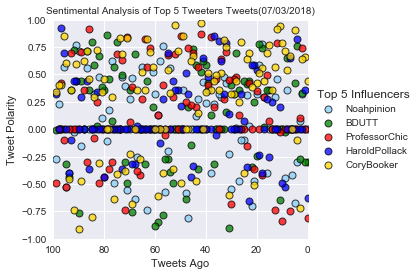

In [44]:
# IB Creating Sentiment Analysis for Top Ten Influences Scatter Plot

# Separate media_user_results_df Dataset into 5 parts/ datasets by "Media Source"
tw1_tweet_data_df = Twitters_overall_results_df[Twitters_overall_results_df['Twitter'] == "@Noahpinion"] 
tw2_tweet_data_df = Twitters_overall_results_df[Twitters_overall_results_df['Twitter'] == "@BDUTT"] 
# For each of media sources following the first one in the media dataset reset index to 0-99
# in order to plot in the common area
tw2_tweet_data_df = tw2_tweet_data_df.reset_index(drop=True)
tw3_tweet_data_df = Twitters_overall_results_df[Twitters_overall_results_df['Twitter'] == "@ProfessorChic"] 
tw3_tweet_data_df = tw3_tweet_data_df.reset_index(drop=True)
tw4_tweet_data_df = Twitters_overall_results_df[Twitters_overall_results_df['Twitter'] == "@haroldpollack"] 
tw4_tweet_data_df = tw4_tweet_data_df.reset_index(drop=True)
tw5_tweet_data_df = Twitters_overall_results_df[Twitters_overall_results_df['Twitter'] == "@CoryBooker"] 
tw5_tweet_data_df = tw5_tweet_data_df.reset_index(drop=True)

# Get the values for each part of the scatter plot by "Twitter"
# TW1
# Get values for X axis
tw1_tweet_ago_data = tw1_tweet_data_df.index
# Get values for Y axis
tw1_tweet_polarity_data = tw1_tweet_data_df["Compound"] 
####################################################################
# TW2
# Get values for X axis
tw2_tweet_ago_data = tw2_tweet_data_df.index 
# Get values for Y axis
tw2_tweet_polarity_data = tw2_tweet_data_df["Compound"] 
####################################################################
# TW3
# Get values for X axis
tw3_tweet_ago_data = tw3_tweet_data_df.index
# Get values for Y axis
tw3_tweet_polarity_data = tw3_tweet_data_df["Compound"] 
####################################################################
# TW4
# Get values for X axis
tw4_tweet_ago_data = tw4_tweet_data_df.index
# Get values for Y axis
tw4_tweet_polarity_data = tw4_tweet_data_df["Compound"] 
####################################################################
# TW5
# Get values for X axis
tw5_tweet_ago_data = tw5_tweet_data_df.index
# Get values for Y axis
tw5_tweet_polarity_data = tw5_tweet_data_df["Compound"] 
###################################################################

# Organize the layout for the scatter plot
plt.title("Sentimental Analysis of Top 5 Tweeters Tweets(07/03/2018)", Fontsize= 10 )

# Labels for the scatter plot circles for each Twitter
labels = ["Noahpinion" "BDUTT" "ProfessorChic" "HaroldPollack" "CoryBooker"]
# Colors for the scatter plot circles for each Twitter
colors = ["lightskyblue","green","red", "blue", "gold"]

# Define X and Y of the scatter plot
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity")

# Define X and Y limits
plt.xlim(100, 0)
plt.ylim( -1.0, 1.0 )

# Writing data to the same Scatter Plot 5 times, for each Twitter 
#           ( "Noahpinion" "BDUTT" "ProfessorChic" "HaroldPollack" "CoryBooker")
plt.scatter( tw1_tweet_ago_data, tw1_tweet_polarity_data, c="lightskyblue", edgecolor="black", 
            linewidths=1, alpha =0.75, marker='o', label="Noahpinion")
plt.scatter( tw2_tweet_ago_data, tw2_tweet_polarity_data, c="green", edgecolor="black", \
            linewidths=1, alpha=0.75, marker='o', label="BDUTT")
plt.scatter( tw3_tweet_ago_data, tw3_tweet_polarity_data, c="red", edgecolor="black", 
            linewidths=1, alpha=0.75, marker='o', label="ProfessorChic")
plt.scatter( tw4_tweet_ago_data, tw4_tweet_polarity_data, c="blue", edgecolor="black", 
            linewidths=1, alpha=0.75, marker='o', label="HaroldPollack")
plt.scatter( tw5_tweet_ago_data, tw5_tweet_polarity_data, c="gold", edgecolor="black", 
            linewidths=1, alpha=0.75, marker='o', label="CoryBooker")
 
# Create the legend of the Scatter plot
legend = plt.legend(fontsize="small", loc="center left", title="Top 5 Influencers", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.grid(True)

# Save the figure with the Scatter Plot
plt.savefig("OutPut/TweetersSentimentsTweeterPolarityScatterPlot.png")

# Show the Scatter Plot
plt.show()

In [45]:
# WIP
# influencersDictionary = {}
# colors = ["yellow","lime","red","orange","pink","yellow","lime","red","orange","pink"]
# index = 0
# for person in Influencers:
#     influencersDictionary[person] = colors[index]
#     index+=1
# influencersDictionary

In [46]:
# # Create an array of Influencers Houses with the unique function in the data frame
# Influencers_array = Sentiment_DF["Influencers"].unique()
# Influencers_array

# # #Plotting the graph for each influencer
# for influencer in Influencers_array:
# # Creating a temporary data frame to store for only one influencer at a time
#         Temp_DF = Sentiment_DF[Sentiment_DF["influencer"] == influencer]
        
#         Sentiment_DF['influencer'] = Sentiment_DF['influencer'].map(lambda x: x.lstrip('@'))
# #Temp_DF
    
#         plt.scatter(Temp_DF["Tweets Ago"],Temp_DF["Compound"]
#                  , marker = "o", linewidth = 0, alpha = 0.8, label = Influencers
#                  , facecolors = Temp_DF.influencer.map(influencersDictionary)
#                 )

# # # Set the legend 
# plt.legend(bbox_to_anchor = (1,1), title="The Influencers", loc='best')

# # # Set the labels of x_axis, y_axis & title 
# plt.xlabel("Tweets Ago", fontsize=12)
# plt.ylabel("Tweet Polarity", fontsize=12)
# plt.title("Sentiment Analysis of The Influencers Tweets (%s)" % (time.strftime("%x")), fontsize=16)

# # #Set the limite of  x_axis and y_axis
# plt.xlim(0, 101)
# plt.ylim(-1,1)

# # # Set the grid
# plt.grid(True)

# filePath = 'Images'
# if not path.exists(filePath):
#     makedirs(filePath)

# # Save the result to a .png file
# plt.savefig("Sentiment Analysis of Influencers Tweets.png",bbox_inches='tight')
# # plt.savefig("Sentiment Analysis of The influencer's Tweets.png",bbox_inches='tight')

# plt.show()

In [47]:
# Version: 2.0
# Date: Mon July 2nd, 2018 
# Time: 10:25 PM

# Functionalities: 
# A) Data Analysis
#     1. Created dataframe.
#     2. Sorting
# B) Sentiment Analysis

# WIP (Work in progress)
# 1. Tweet bot. The git part is done. 
# Automation is pending as hosting might need neet tech which we have not covered now.

# Pending items:
# 1. Data Cleaning
# 2. Graphs and plots
# 3. Testing

In [48]:
# Version: 3.0 - IB
# Date: Monday 7/3/2018
# Time: 3:00 PM
# Functionalities: 
# A) Overcame _TweepError - 34_ by using max_id logic while calling api.user_timeline Tweepy function
#    Sentiment Analysis for Top 5 Influencers and Top 5 Twitters function 
# B) Created the Scatter Plot for Sentimental Analysis of Top 5 Influencers last 100 tweets
# C) Created the Scatter Plot for Sentimental Analysis of Top 5 Twitters last 100 tweets
#    Scatter Plots png files are saved in OutPut directory
#
# These Scatter Plots visualize a great difference between _overal_ ratings of Influencers and People who tweet most
# 
# For Merging: Code has # IB comments, 8 cells. When "Restart and Run All" Kernel, my code is in ln[37] to ln[44]
# With amount of tweets we have it runs under 10 minutes